In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

In [2]:
import pymc3 as pm

In [3]:
np.random.seed(23) # from random.org

# 3.1. Hierarchical GLAM estimation and out of sample prediction

## Load data

In [4]:
# Load data
sufix = 'hierarchical_More_NoBin_Gamma-11_NUTS_33'
data = pd.read_csv('data/PF2019_data/GlamDataPF2019_More_NoBin_33.csv')
#data = pd.read_csv('data/PF2019_data/GlamDataFF2018_Like_NoBin.csv')

# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,1,0,1,1734.284,110,131,0.669090,0.330910
1,1,1,0,6555.370,47,50,0.759630,0.240370
2,1,2,0,3174.566,50,44,0.549371,0.450629
3,1,3,1,2877.579,57,50,0.608409,0.391591
4,1,4,1,1806.310,42,50,0.522849,0.477151


## Split data in training and test sets

In [7]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1920 trials) and test (1920 trials) sets...


In [8]:
train_data

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,1,0,1,1734.284,110,131,0.669090,0.330910
2,1,2,0,3174.566,50,44,0.549371,0.450629
4,1,4,1,1806.310,42,50,0.522849,0.477151
6,1,6,1,3650.266,78,80,0.682034,0.317966
8,1,8,1,1259.268,50,48,0.508019,0.491981
10,1,10,1,5698.027,46,50,0.582089,0.417911
12,1,12,1,2626.168,50,56,0.666353,0.333647
14,1,14,1,1671.149,110,124,0.508035,0.491965
16,1,16,1,1527.826,64,80,0.473512,0.526488
18,1,18,1,2267.665,101,110,0.553242,0.446758


## Hierarchical GLAM estimation

### 1. full GLAM

In [9]:
# Fitting full GLAM
print('Fitting full GLAM hierarchically...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_full_hierarchical_cv'+sufix+'.npy')):
    glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_PF2019_full_hierarchical_cv'+sufix+'.npy'))   

Fitting full GLAM hierarchically...
Generating single subject models for 32 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 32 model(s) using NUTS...
  Fitting model 1 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1038.95draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 2 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:18<00:00, 651.95draws/s]
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 3 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:14<00:00, 830.78draws/s]
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 4 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:14<00:00, 817.96draws/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 5 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 943.83draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 6 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:14<00:00, 818.01draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8799485849873582, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8981774391494725, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 7 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:18<00:00, 646.57draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 8 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 881.33draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 9 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1014.74draws/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 10 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 945.76draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6988306481239942, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 11 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 890.26draws/s]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 12 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1075.98draws/s]
The acceptance probability does not match the target. It is 0.8849509223576897, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6966123193269532, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 13 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [11:50<00:00,  3.88draws/s]
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.652840423067064, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8799764671095479, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigni

  Fitting model 14 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1064.56draws/s]
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 15 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:16<00:00, 711.24draws/s]
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 16 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:25<00:00, 467.16draws/s]
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9100193217790833, but should be close to 0.8. Try to increase the number of tuning steps.
There were 449 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.558953569611484, but should be close to 0.8. Try to increase the number of tuning steps.
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5587931752794926, but should be close to 0.8. Try to increase the number of tuning steps.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 

  Fitting model 17 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 943.84draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8794101178300339, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 18 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1210.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 19 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:30<00:00, 398.73draws/s]
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6525463358732884, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9356809315434799, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6896103745502107, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some 

  Fitting model 20 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:20<00:00, 597.15draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 21 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1040.17draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.896292655029272, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 22 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 875.57draws/s]
There were 1243 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1189 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1098 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1272 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 23 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 962.33draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8871559125146787, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 24 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:15<00:00, 791.67draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 25 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1003.10draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 26 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:16<00:00, 711.77draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 27 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:12<00:00, 949.41draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9024634839476384, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8907039117862787, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 28 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [16:02<00:00,  7.14draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9170981570841957, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 29 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:39<00:00, 306.61draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 30 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 904.52draws/s]
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 31 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 917.08draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4775538612458078, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 32 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:15<00:00, 761.01draws/s]
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [15]:
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_nobias_hierarchical_cv'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

,SNR,b,gamma,p_error,s,t0,tau,v
0,203.91,1.0,0.85,0.05,0.009766,[0.0],0.28,0.000041
1,484.37,1.0,0.89,0.05,0.005238,[0.0],0.29,0.000012
2,300.85,1.0,-0.09,0.05,0.007449,[0.0],0.13,0.000031
3,462.96,1.0,0.98,0.05,0.010301,[0.0],0.17,0.000022
4,173.23,1.0,0.68,0.05,0.005436,[0.0],0.13,0.000031
5,152.61,1.0,0.63,0.05,0.007799,[0.0],0.08,0.000043
6,404.11,1.0,0.82,0.05,0.011048,[0.0],0.10,0.000025
7,123.62,1.0,-0.27,0.05,0.007531,[0.0],0.06,0.000052
8,54.69,1.0,0.99,0.05,0.005685,[0.0],0.02,0.000095
9,185.80,1.0,0.08,0.05,0.009549,[0.0],0.32,0.000040


In [10]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_PF2019_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_PF2019_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_PF2019_full'+ sufix +'.npy'), glam_full.waic)

Computing WAIC scores for full model...


/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance

In [11]:
glam_full.waic

array([[1.04604884e+03, 0.00000000e+00, 1.72250244e+00, 1.00000000e+00],
       [1.22067883e+03, 0.00000000e+00, 1.77895232e+00, 1.00000000e+00],
       [1.08131950e+03, 0.00000000e+00, 4.57825376e+00, 1.00000000e+00],
       [1.19129127e+03, 0.00000000e+00, 1.81216772e+00, 1.00000000e+00],
       [1.09360688e+03, 0.00000000e+00, 2.09341500e+00, 1.00000000e+00],
       [1.07141022e+03, 0.00000000e+00, 3.96698860e+00, 1.00000000e+00],
       [1.16532728e+03, 0.00000000e+00, 1.59540281e+00, 1.00000000e+00],
       [1.04997833e+03, 0.00000000e+00, 2.34431071e+00, 1.00000000e+00],
       [9.92213429e+02, 0.00000000e+00, 2.57769666e+00, 1.00000000e+00],
       [1.03406225e+03, 0.00000000e+00, 2.59437231e+00, 1.00000000e+00],
       [1.20205192e+03, 0.00000000e+00, 3.10274965e+00, 1.00000000e+00],
       [1.00093682e+03, 0.00000000e+00, 2.61991370e+00, 1.00000000e+00],
       [1.05702793e+03, 0.00000000e+00, 1.21914822e+01, 1.00000000e+00],
       [1.07529609e+03, 0.00000000e+00, 3.57531961e

In [ ]:
# Compute LOO

glam_full.loo = pm.loo(trace=glam_full.trace, model=glam_full.model)
glam_full.loo
np.save(str('results/loo/glam_PF2019_full'+ sufix +'.npy'), glam_full.loo)

In [18]:
glam_full.loo

AttributeError: 'GLAM' object has no attribute 'loo'

In [19]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_full_hierarchical_cv'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_PF2019_full_hierarchical_cv'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1980 trials) with new data (1980 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,0.0,1.0,4618.0,47,0.490772,50,0.509228
1,0.0,0.0,1.0,0.0,3511.0,47,0.490772,50,0.509228
2,0.0,0.0,2.0,1.0,3231.0,47,0.490772,50,0.509228
3,0.0,0.0,3.0,1.0,4558.0,47,0.490772,50,0.509228
4,0.0,0.0,4.0,1.0,2279.0,47,0.490772,50,0.509228


### 1. no-bias GLAM

In [ ]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM hierarchically...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_nobias_hierarchical_cv'+sufix+'.npy')):
    glam_nobias.make_model('hierarchical', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_PF2019_nobias_hierarchical_cv'+sufix+'.npy'))
 

In [ ]:
   
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_nobias_hierarchical_cv'+sufix+'.npy'), glam_nobias.estimates)
pd.DataFrame(glam_nobias.estimates)

In [ ]:
# In case it is already fitted
params_part_like = pd.DataFrame.from_dict(glam_nobias.estimates.item(0))
params_part_like

In [ ]:
# Compute LOO

glam_nobias.loo = pm.loo(trace=glam_nobias.trace, model=glam_nobias.model)
glam_nobias.loo

np.save(str('results/loo/glam_PF2019_nobias'+ sufix +'.npy'), glam_nobias.loo
)

In [ ]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_nobias_hierarchical_cv'+sufix+'.csv')):
    glam_nobias.predict(n_repeats=50)
    glam_nobias.prediction.to_csv(str('results/predictions/glam_PF2019_nobias_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...')
    glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_PF2019_nobias_hierarchical_cv'+sufix+'.csv'))

glam_nobias.prediction.head()

## 2. Plot fit

Close Figure to continue...


IndexError: index 2 is out of bounds for axis 0 with size 2

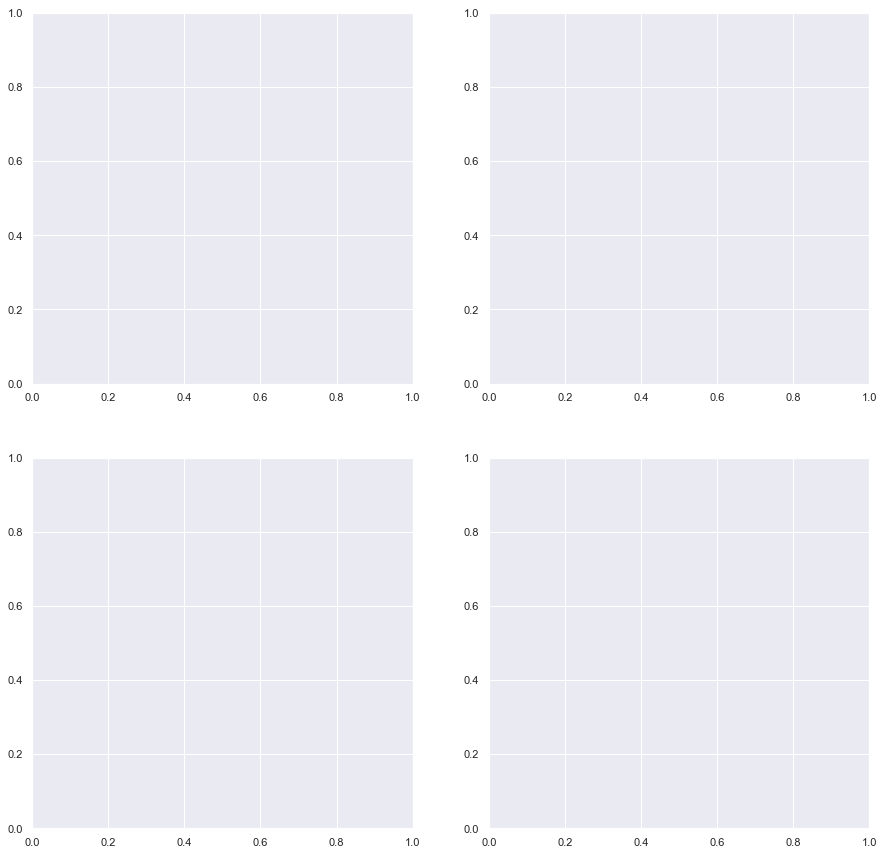

In [20]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
#glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## Parameters for full hierarchical model

In [24]:
params_participant = glam_full.estimates
params_participant

[{'b': 1.0,
  'p_error': 0.05,
  'v': 5.1e-05,
  'gamma': -0.77,
  'SNR': 125.41,
  's': 0.0081,
  'tau': 0.01,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 1.6e-05,
  'gamma': -0.99,
  'SNR': 290.78,
  's': 0.006238,
  'tau': 0.05,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 3.5e-05,
  'gamma': -0.11,
  'SNR': 230.96,
  's': 0.008048,
  'tau': 0.11,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 2.1e-05,
  'gamma': -0.99,
  'SNR': 434.59,
  's': 0.009583,
  'tau': 0.1,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 3.2e-05,
  'gamma': -0.99,
  'SNR': 165.04,
  's': 0.005638,
  'tau': 0.06,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 5.7e-05,
  'gamma': -0.71,
  'SNR': 83.7,
  's': 0.005543,
  'tau': 0.09,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 3e-05,
  'gamma': -0.99,
  'SNR': 232.79,
  's': 0.008216,
  'tau': 0.08,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 5.1e-05,
  'gamma

In [21]:
params_participant = pd.DataFrame.from_dict(glam_full.estimates.item(0))

AttributeError: 'list' object has no attribute 'item'

In [ ]:
params_participant

In [ ]:
print ("Mean gamma " +  str(params_participant['gamma'].mean()))

In [ ]:
hist = params_participant[['SNR','gamma','tau','v']].hist(figsize = [20,3] , layout=[1,4],bins = 20)

## [END] 